In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, normalize
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [4]:
data_src = "./football_data.csv"
df = pd.read_csv(data_src, )

In [5]:
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Agglomerative clustering

In [94]:
attributes = ["Overall","Age"]
attribute_weights = [1,1]

attributes=['Age', 'Overall', 'Potential', 'International Reputation', 'Weak Foot', 'Skill Moves', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']
filters = attributes

df.fillna(method ='ffill', inplace = True)
df_filtered = df[filters]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtered)

df_normalized = normalize(df_scaled)

df_normalized = pd.DataFrame(df_normalized)

#PCA to reduce dimensionality to 2 features
pca = PCA(n_components = 2)
df_principal = pca.fit_transform(df_normalized)
df_principal = pd.DataFrame(df_principal)
df_principal.columns = ['P1', 'P2']

attributes = ['P1','P2']
data = []
for i, r in df_principal.iterrows():
    single_point=[]
    for j in range(len(attributes)):
        single_point.append(r[attributes[j]]*attribute_weights[j])
        
    data.append(single_point)

In [40]:
data_part = data

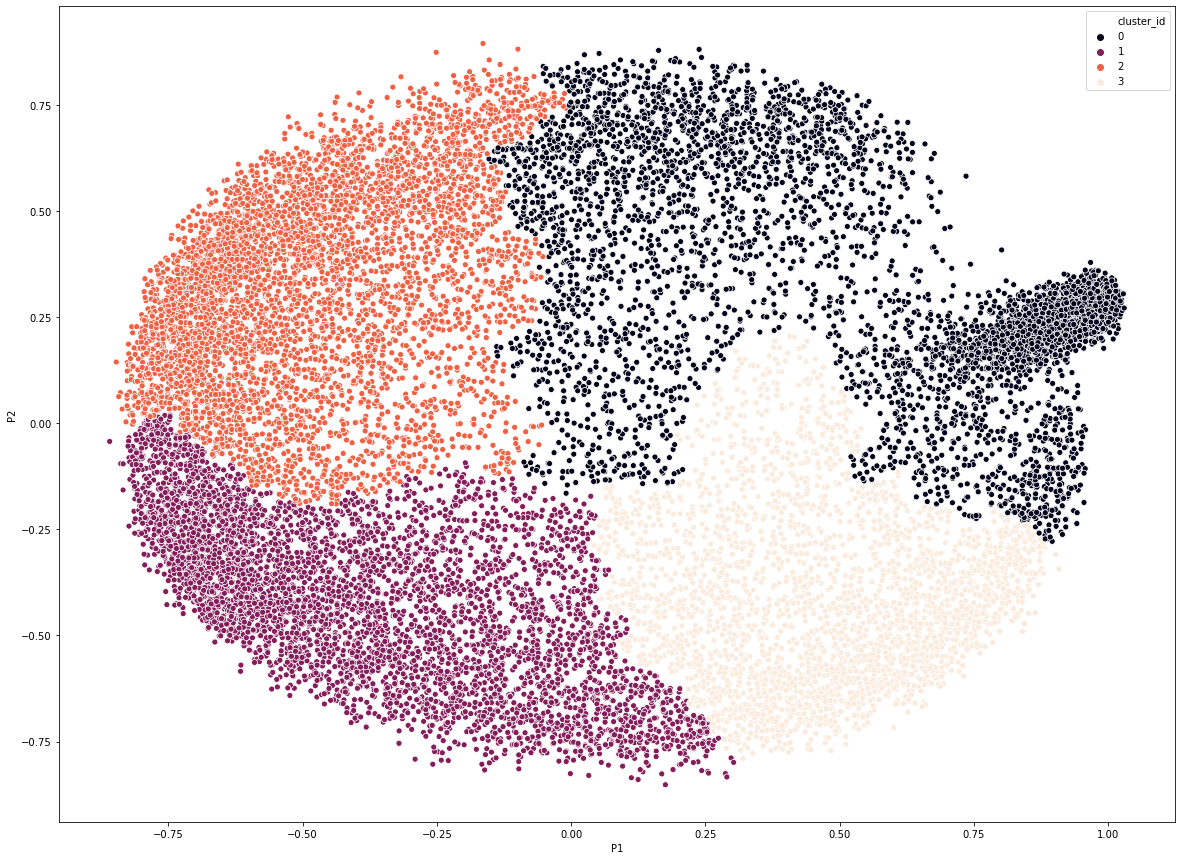

In [116]:
agglo_clustering = AgglomerativeClustering(n_clusters=4).fit(data)
df_principal['cluster_id']=agglo_clustering.labels_

fig = plt.figure(figsize=(20,15))
sns.scatterplot(data=df_principal, x='P1', y='P2', hue='cluster_id', palette="rocket")
plt.show()

for n=3

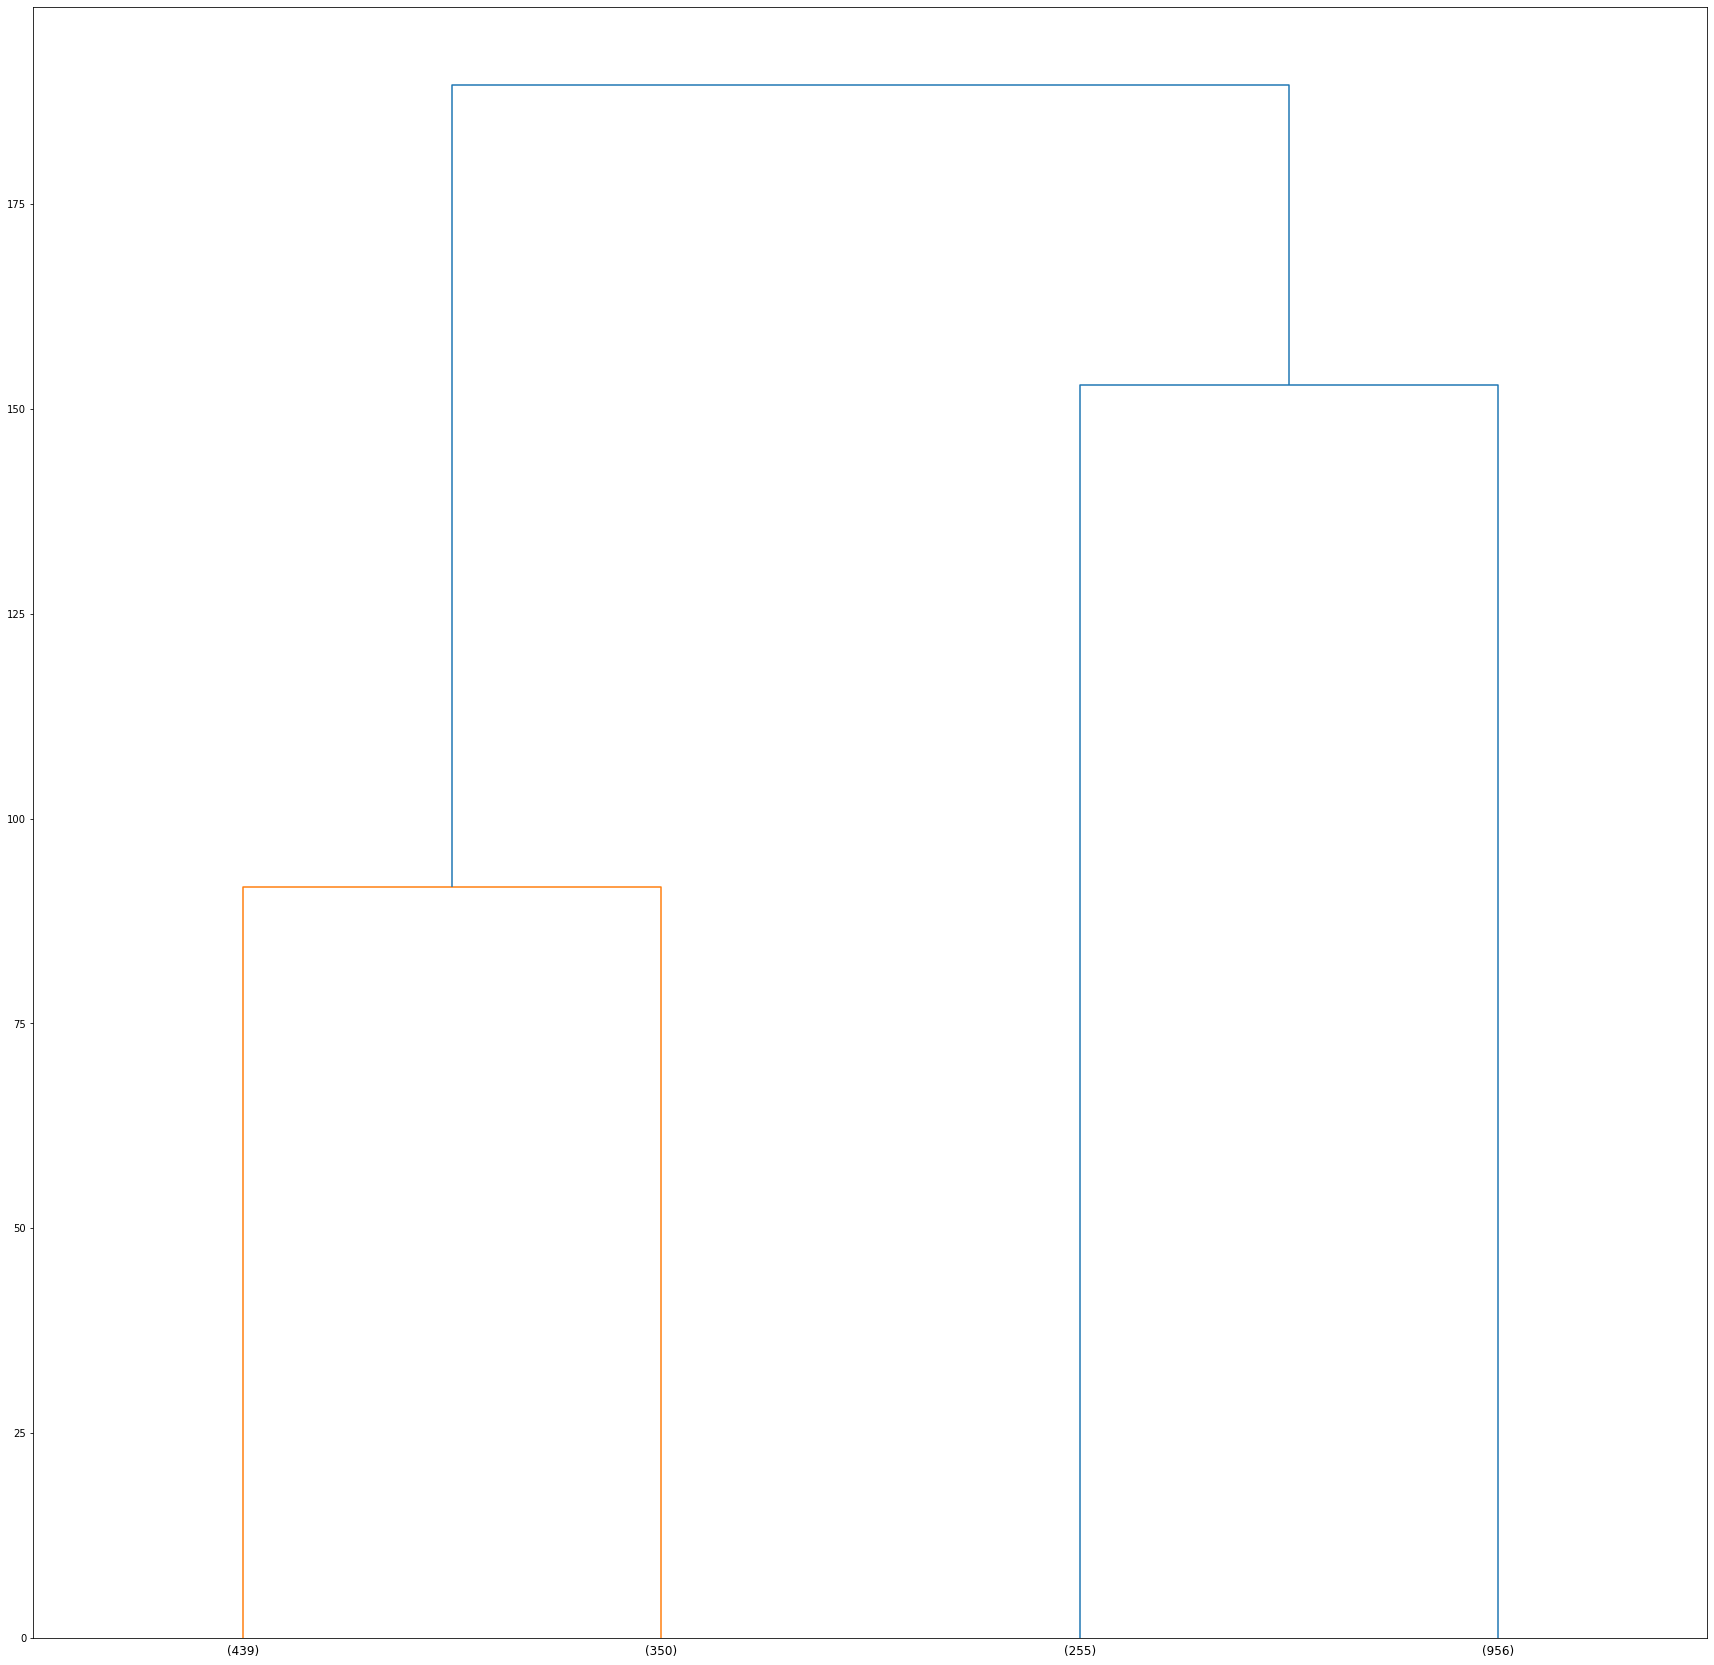

In [115]:
agglo = linkage(data_part, 'ward')
fig = plt.figure(figsize=(30, 30))
dn = dendrogram(Z=agglo, p=1, truncate_mode="level")
plt.show()

this is the corresponding dendogram

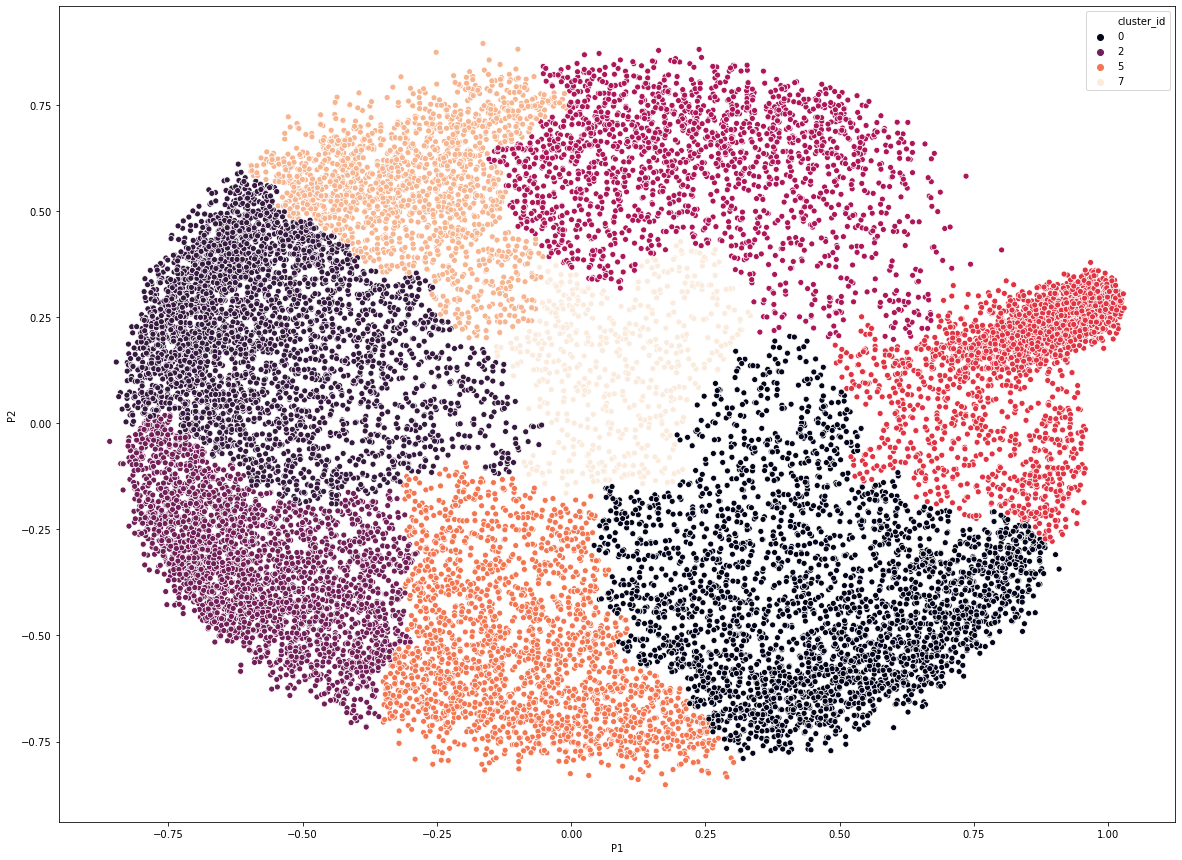

In [114]:
agglo_clustering = AgglomerativeClustering(n_clusters=8).fit(data)
df_principal['cluster_id']=agglo_clustering.labels_

fig = plt.figure(figsize=(20,15))
sns.scatterplot(data=df_principal, x='P1', y='P2', hue='cluster_id', palette="rocket")
plt.show()



this is for n=5

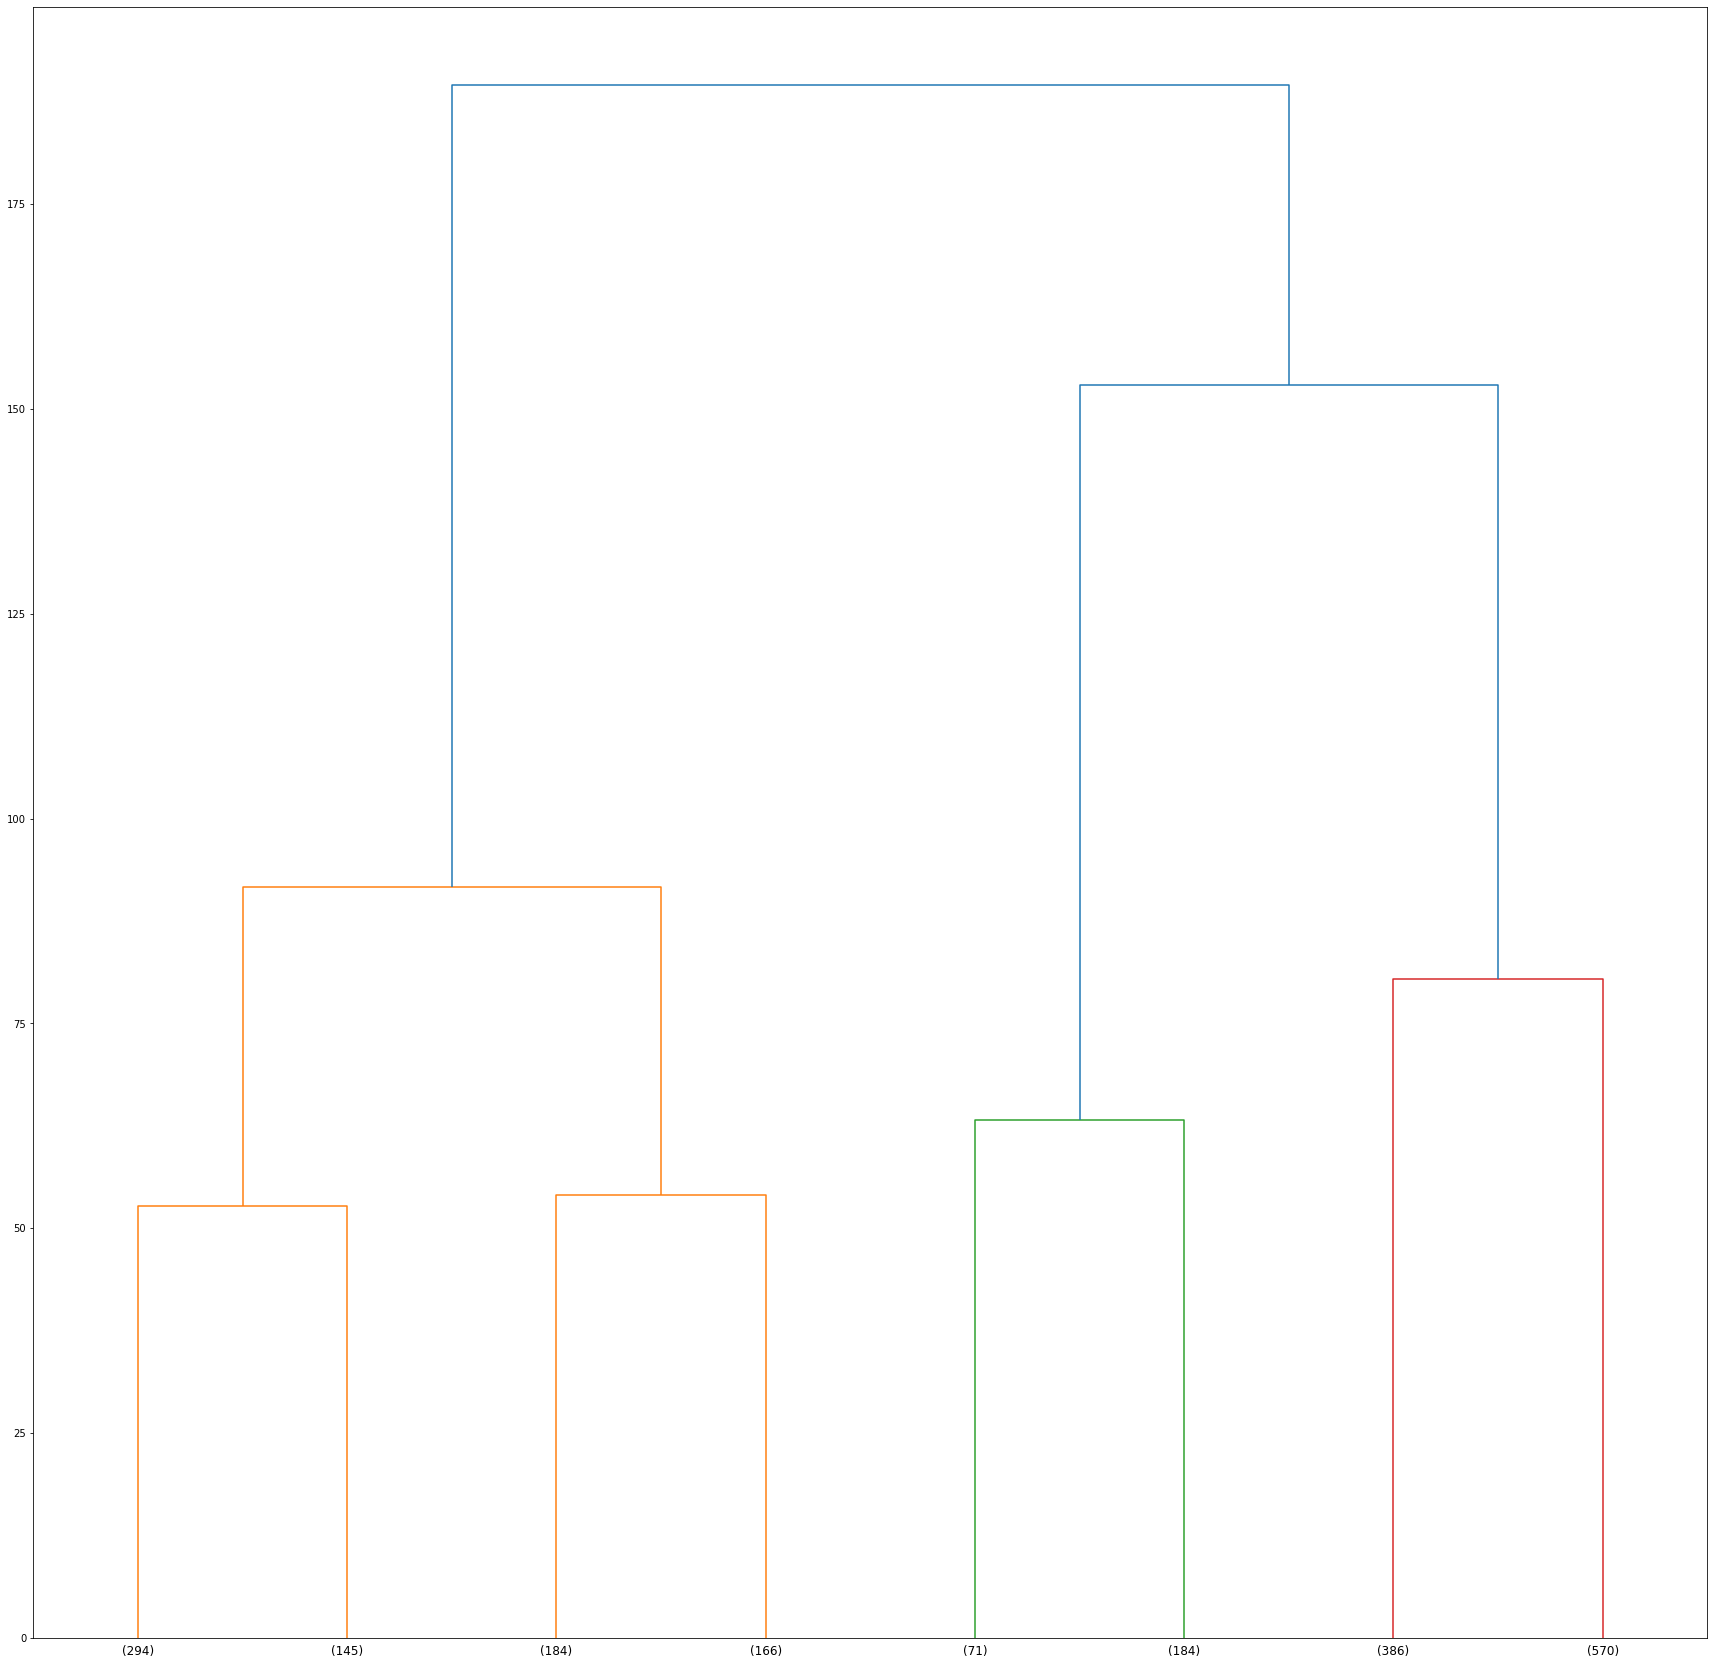

In [113]:
agglo = linkage(data_part, 'ward')
fig = plt.figure(figsize=(30, 30))
dn = dendrogram(Z=agglo, p=2, truncate_mode="level")
plt.show()

and corresponding dendogram

## Divisive Clustering

In [42]:
def distance(a,b):
    dist=0
    for i in range(len(a)):
        dist += (a[i]-b[i])**2
    return np.sqrt(dist)
    
def calc_distance(Ci, Cj):
    return min(distance(i, j) for i in Ci for j in Cj)

In [43]:
def split_cluster(new_data,kmeans):
    new_data=np.array(new_data)
    temp = np.all(new_data == new_data[0,:], axis = 0)
    flag = (temp==True).all()
    if flag:
        c0 = new_data[:new_data.shape[0]//2]
        c1 = new_data[new_data.shape[0]//2:]
    else:
        new_kmeans = kmeans.fit(new_data)
        c0 = new_data[new_kmeans.labels_==0]
        c1 = new_data[new_kmeans.labels_==1]
    return c0,c1

In [52]:
def calc_quality(cluster):
    if(cluster.shape[0]==1):
        return 0
    mean_cluster = np.mean(cluster)
    diff = cluster- mean_cluster
    diff = diff**2
    return np.sum(diff)

def checker(curr_cluster):
    for i in curr_cluster:
        if i.shape[0]!=1:
            return True
    return False
    
def conv_str(cluster):
    newlist = []
    for i in cluster:
        newlist.append(str(list(i)))
    return(str(newlist))

In [54]:
calc_quality(np.array([[1,0]]))

0

In [55]:
def divisive_split_sse(data, kmeans,size):
    linkage_matrix=[]
    id_no = 0
    clusters ={}
    clusters[id_no]=data
    cluster_no={}
    cluster_no[conv_str(data)]=id_no
    id_no+=1
    curr_clusters=[np.array(data)]
    
    while(checker(curr_clusters)):
        print(id_no, end=" ")
        # for i in curr_clusters:
        #     print(i.shape[0], end="  ")
        # print()
        cluster_quality = []
        for i in curr_clusters:
            cluster_quality.append(calc_quality(i))
        spliter_cluster_index = cluster_quality.index(max(cluster_quality))
        spliter_cluster = curr_clusters.pop(spliter_cluster_index)
        c0, c1 = split_cluster(spliter_cluster,kmeans)
        curr_clusters.append(c0)
        curr_clusters.append(c1)
        
        curr_id_no = cluster_no[conv_str(spliter_cluster)]
        
        linkage_matrix.append([id_no,id_no+1,curr_id_no,calc_distance(c0,c1),spliter_cluster.shape[0]])

        clusters[id_no]=c0
        cluster_no[conv_str(c0)]=id_no
        id_no+=1
        clusters[id_no]=c1
        cluster_no[conv_str(c1)]=id_no
        id_no+=1
    linkage_matrix.reverse()
    return clusters, np.array(linkage_matrix)



In [91]:
n=2000
data_part = data[:n]
kmeans = KMeans(n_clusters=2,random_state=0, max_iter=10)
clusters, linkage_matrix = divisive_split_sse(data_part,kmeans,2*n-1)
# print(clusters)
# print(linkage_matrix)

1 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81 83 85 87 89 91 93 95 97 99 101 103 105 107 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179 181 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213 215 217 219 221 223 225 227 229 231 233 235 237 239 241 243 245 247 249 251 253 255 257 259 261 263 265 267 269 271 273 275 277 279 281 283 285 287 289 291 293 295 297 299 301 303 305 307 309 311 313 315 317 319 321 323 325 327 329 331 333 335 337 339 341 343 345 347 349 351 353 355 357 359 361 363 365 367 369 371 373 375 377 379 381 383 385 387 389 391 393 395 397 399 401 403 405 407 409 411 413 415 417 419 421 423 425 427 429 431 433 435 437 439 441 443 445 447 449 451 453 455 457 459 461 463 465 467 469 471 473 475 477 479 481 483 485 487 489 491 493 495 497 499 501 503 505 507 509 511 513 515 517 519 521 523 525 527

In [84]:
clusters

{0: [[94, 31],
  [94, 33],
  [92, 26],
  [91, 27],
  [91, 27],
  [91, 27],
  [91, 32],
  [91, 31],
  [91, 32],
  [90, 25],
  [90, 29],
  [90, 28],
  [90, 32],
  [90, 32],
  [89, 27],
  [89, 24],
  [89, 24],
  [89, 27],
  [89, 26],
  [89, 26]],
 1: array([[94, 31],
        [94, 33],
        [91, 32],
        [91, 31],
        [91, 32],
        [90, 32],
        [90, 32]]),
 2: array([[92, 26],
        [91, 27],
        [91, 27],
        [91, 27],
        [90, 25],
        [90, 29],
        [90, 28],
        [89, 27],
        [89, 24],
        [89, 24],
        [89, 27],
        [89, 26],
        [89, 26]]),
 3: array([[92, 26],
        [91, 27],
        [91, 27],
        [91, 27],
        [90, 29],
        [90, 28],
        [89, 27],
        [89, 27]]),
 4: array([[90, 25],
        [89, 24],
        [89, 24],
        [89, 26],
        [89, 26]]),
 5: array([[90, 29],
        [90, 28],
        [89, 27],
        [89, 27]]),
 6: array([[92, 26],
        [91, 27],
        [91, 27],
        

these are the clusters for divisive clustering

In [85]:
linkage_matrix

array([[37.        , 38.        , 11.        ,  0.        ,  2.        ],
       [35.        , 36.        , 21.        ,  0.        ,  2.        ],
       [33.        , 34.        , 15.        ,  1.        ,  2.        ],
       [31.        , 32.        , 16.        ,  0.        ,  2.        ],
       [29.        , 30.        ,  8.        ,  2.        ,  2.        ],
       [27.        , 28.        , 20.        ,  0.        ,  2.        ],
       [25.        , 26.        , 18.        ,  0.        ,  2.        ],
       [23.        , 24.        , 10.        ,  0.        ,  2.        ],
       [21.        , 22.        , 12.        ,  1.        ,  3.        ],
       [19.        , 20.        ,  9.        ,  1.41421356,  3.        ],
       [17.        , 18.        , 14.        ,  0.        ,  3.        ],
       [15.        , 16.        ,  5.        ,  1.41421356,  4.        ],
       [13.        , 14.        ,  6.        ,  1.41421356,  4.        ],
       [11.        , 12.        ,  7. 

In [86]:
new_linkage_matrix = []

sort_dist_linkage_matrix = list(linkage_matrix[:,-2])
# print(sort_dist_linkage_matrix)

sort_dist_linkage_matrix = list(set(sort_dist_linkage_matrix))
sort_dist_linkage_matrix.sort()
# print(sort_dist_linkage_matrix)
sorted_linkage_matrix = []
for i in sort_dist_linkage_matrix:
    for j in linkage_matrix:
        # print(i,j)
        # exit()
        if i==j[-2]:
            sorted_linkage_matrix.append(j)

sorted_linkage_matrix = linkage_matrix

label_dist={}
counter1 = 0
counter2 = n
for i in sorted_linkage_matrix:
    if i[-1] == 2:
        label_dist[i[0]]= counter1
        counter1+=1
        label_dist[i[1]] = counter1
        counter1+=1
        label_dist[i[2]] = counter2
        new_linkage_matrix.append([label_dist[i[0]],label_dist[i[1]],i[-2],i[-1]])
    
    else:
        if i[0] not in label_dist:
            label_dist[i[0]] = counter1
            counter1+=1
        if i[1] not in label_dist:
            label_dist[i[1]] = counter1
            counter1+=1
        label_dist[i[2]] = counter2
        new_linkage_matrix.append([label_dist[i[0]],label_dist[i[1]],i[-2],i[-1]])
    counter2+=1

print(counter1,counter2)



20 39


In [87]:
linkage_matrix,sorted_linkage_matrix, new_linkage_matrix

(array([[37.        , 38.        , 11.        ,  0.        ,  2.        ],
        [35.        , 36.        , 21.        ,  0.        ,  2.        ],
        [33.        , 34.        , 15.        ,  1.        ,  2.        ],
        [31.        , 32.        , 16.        ,  0.        ,  2.        ],
        [29.        , 30.        ,  8.        ,  2.        ,  2.        ],
        [27.        , 28.        , 20.        ,  0.        ,  2.        ],
        [25.        , 26.        , 18.        ,  0.        ,  2.        ],
        [23.        , 24.        , 10.        ,  0.        ,  2.        ],
        [21.        , 22.        , 12.        ,  1.        ,  3.        ],
        [19.        , 20.        ,  9.        ,  1.41421356,  3.        ],
        [17.        , 18.        , 14.        ,  0.        ,  3.        ],
        [15.        , 16.        ,  5.        ,  1.41421356,  4.        ],
        [13.        , 14.        ,  6.        ,  1.41421356,  4.        ],
        [11.        , 12.

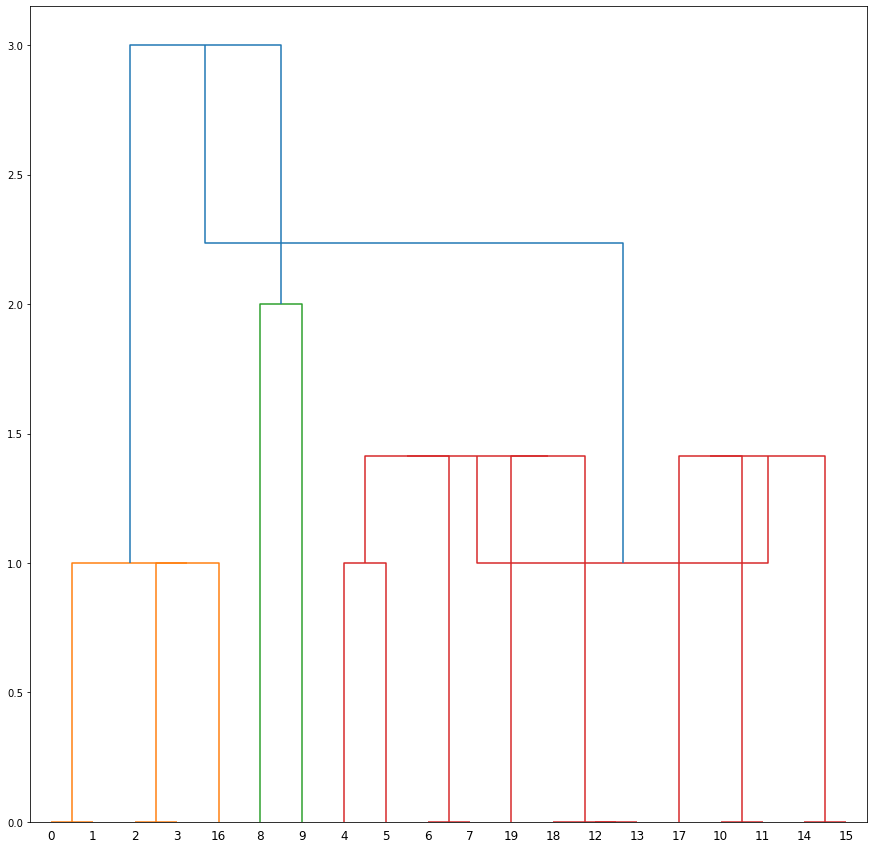

In [88]:
fig = plt.figure(figsize=(15, 15))
dn = dendrogram(np.array(new_linkage_matrix))
plt.show()

dendogram was made for a small dataset using divisive